In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})
plt.rc('font', family='NanumGothic')
import seaborn as sns

# utils
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pickle
import warnings;warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
import eli5
from eli5.sklearn import PermutationImportance


def calculate_pearson(data1, data2):
    corr, p_value = pearsonr(data1, data2)
    return corr, p_value


In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
train.info()

train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])
concat = concat.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [3]:
print(train.shape, test.shape)

(1118822, 53) (9272, 52)


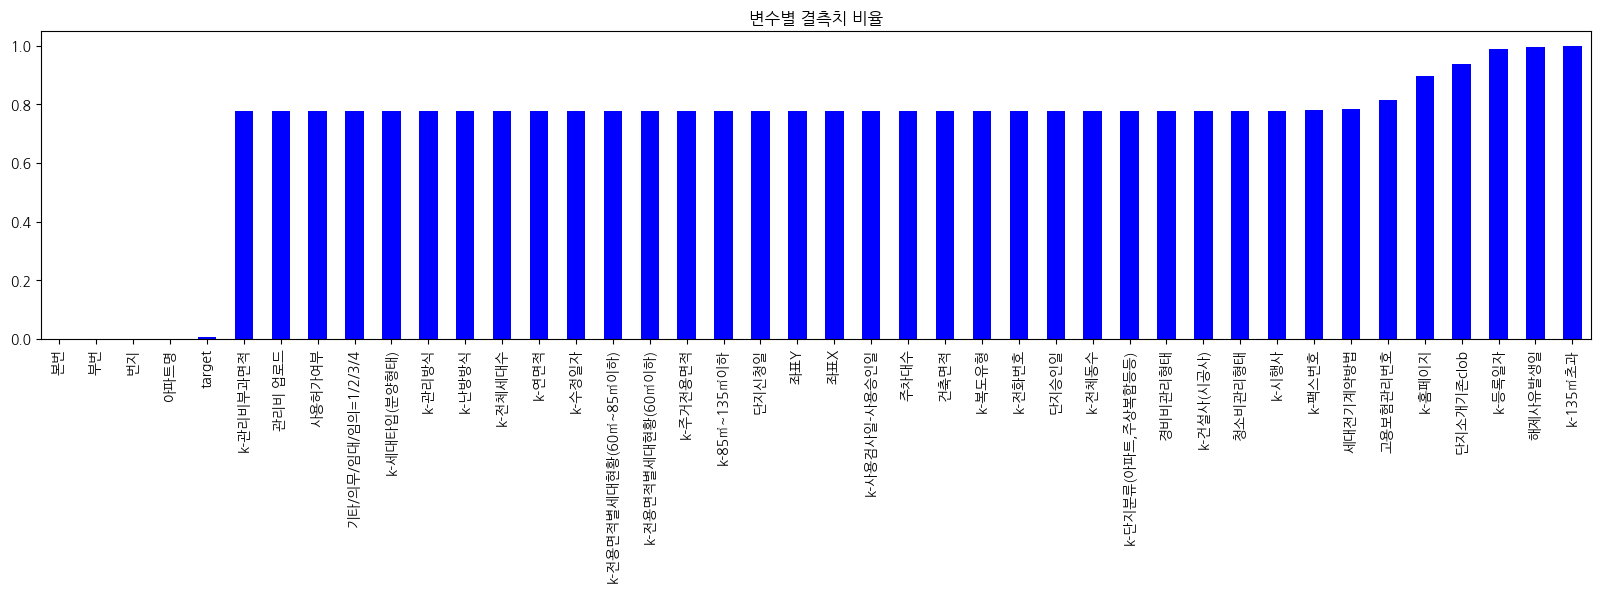

In [4]:
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')

fig = plt.figure(figsize=(20, 4))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='blue')
plt.title('변수별 결측치 비율')
plt.show()

In [7]:
# dataset_org = dataset_org.rename( columns={c: c.replace("k-", "") for c in dataset_org.columns if c.startswith("k-")} )
concat = concat.rename( columns={ c : c[2::] 
                                for c in concat.columns 
                                if "k-" in c })
concat.rename(columns={
    '단지분류(아파트,주상복합등등)': '단지분류',
    '세대타입(분양형태)': '세대타입_분양형태',
    '건설사(시공사)': '건설사_시공사',
    '사용검사일-사용승인일': '사용검사일_사용승인일',
    '전용면적별세대현황(60㎡이하)': '전용면적_60이하',
    '전용면적별세대현황(60㎡~85㎡이하)': '전용면적_60~85이하',
    '85㎡~135㎡이하': '전용면적_85~135이하',
    '135㎡초과' : '전용면적_135초과',
    '전용면적(㎡)' : '전용면적',
    '기타/의무/임대/임의=1/2/3/4': '기타_의무_임대_임의_1_2_3_4'          # 이 변수는 나중에 한번 고려해보자
}, inplace=True)


In [8]:
display(concat.columns)

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지분류', '전화번호', '팩스번호',
       '단지소개기존clob', '세대타입_분양형태', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수',
       '건설사_시공사', '시행사', '사용검사일_사용승인일', '연면적', '주거전용면적', '관리비부과면적',
       '전용면적_60이하', '전용면적_60~85이하', '전용면적_85~135이하', '전용면적_135초과', '홈페이지',
       '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적',
       '주차대수', '기타_의무_임대_임의_1_2_3_4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X',
       '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

## (1) 결측치 및 이상치 처리 -1

In [9]:
# 결측치 100만개 이상 feature 제거
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
selected.append('전용면적_135초과')
concat_select = concat[selected]

In [10]:
concat_select.isnull().sum()

시군구                          0
번지                         227
본번                          75
부번                          75
아파트명                      2136
전용면적                         0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
등기신청일자                       0
거래유형                         0
중개사소재지                       0
단지분류                    877273
전화번호                    876850
팩스번호                    879348
세대타입_분양형태               876125
관리방식                    876125
복도유형                    876454
난방방식                    876125
전체동수                    877207
전체세대수                   876125
건설사_시공사                 877637
시행사                     877834
사용검사일_사용승인일             876259
연면적                     876125
주거전용면적                  876170
관리비부과면적                 876125
전용면적_60이하               876170
전용면적_60~85이하            876170
전용면적_85~135이하           876170
수정일자    

### "층" 이상치 = minus 처리

69


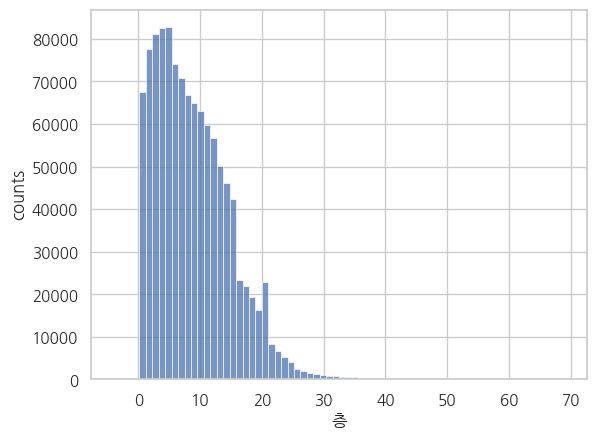

In [11]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')
sns.histplot(concat_select["층"], bins=70)
# sns.histplot(np.sqrt(concat_select["층"]), bins=70)
# plt.scatter(concat_select["층"], concat_select["target"])
plt.xlabel("층")
plt.ylabel("counts")
print(train["층"].max())

In [12]:
concat_select["층"] = abs(concat_select["층"])
concat_select[concat_select["층"] <= 0 ]["층"]

Series([], Name: 층, dtype: int64)

### "좌표X" "좌표Y" 결측치 채우기 (카카오 API) - 1

In [13]:
# import requests

# def get_coordinates_with_fallback(region, bonbun, bubun, api_key):
#     """
#     주소를 단계적으로 축소해가며 좌표를 검색합니다.
#     Parameters:
#     - region (str): 행정구역 (시/도 + 구/군 + 읍/면/동)
#     - bonbun (int): 본번
#     - bubun (int): 부번
#     - api_key (str): Kakao Maps REST API 키
#     Returns:
#     - tuple: (latitude, longitude) 또는 None (오류 시)
#     """
    
#     # 주소를 축소하는 순서대로 리스트 생성
#     addresses = []
#     # if bubun > 0:
#     addresses.append(f"{region} {bonbun}-{bubun}")  # 본번과 부번 포함
#     addresses.append(f"{region} {bonbun}")  # 본번만 포함
#     addresses.append(region)  # 행정구역만 포함

#     url = "https://dapi.kakao.com/v2/local/search/address.json"
#     headers = {"Authorization": f"KakaoAK {api_key}"}

#     for address in addresses:
#         params = {"query": address}
#         try:
#             response = requests.get(url, headers=headers, params=params)
#             response.raise_for_status()
#             result = response.json()

#             if result["documents"]:
#                 # 첫 번째 결과의 좌표 반환
#                 x = result["documents"][0]["x"]  # 경도
#                 y = result["documents"][0]["y"]  # 위도
#                 # print(f"주소 검색 성공: {address}")
#                 return float(y), float(x)
#             else:
#                 # print(f"주소를 찾을 수 없습니다: {address}")
#                 pass

#         except requests.exceptions.HTTPError as e:
#             print(f"HTTP 오류 발생: {e}")
#         except Exception as e:
#             print(f"기타 오류 발생: {e}")
    
#     # 모든 시도가 실패하면 None 반환
#     return None


In [14]:
# unique_addresses = concat_select[['시군구', '본번', '부번']].drop_duplicates()
# unique_addresses
# api_key = '1c97ab54264ea538150a497fe7a76737'

# unique_addresses['coordinates'] = unique_addresses.progress_apply(
#     lambda row: get_coordinates_with_fallback(row['시군구'], row['본번'], row['부번'], api_key=api_key), axis=1
# )

In [15]:
### 데이터 저장 및 백업
# unique_addresses.to_csv('../data/xy_new_v2.csv', columns =["시군구", "본번", "부번", "coordinates"])

In [16]:
# concat_select2 = concat_select.copy()
# concat_select2 = concat_select2.merge(unique_addresses, on=['시군구', '본번', '부번'], how='left')
# concat_select2['좌표Y'] = concat_select2['coordinates'].astype('str').str.split(',', expand=True)[0].str.split('(', expand=True)[1].astype('float')
# concat_select2['좌표X'] = concat_select2['coordinates'].astype('str').str.split(',', expand=True)[1].str.split(')', expand=True)[0].astype('float')
# concat_select2.drop(columns=['coordinates'], axis=1, inplace=True)

In [17]:
# concat_select2.head()

In [18]:
# del concat_select2

### "좌표X" "좌표Y" 결측치 채우기 (카카오 API) - 2

21801 876232
21801 876232


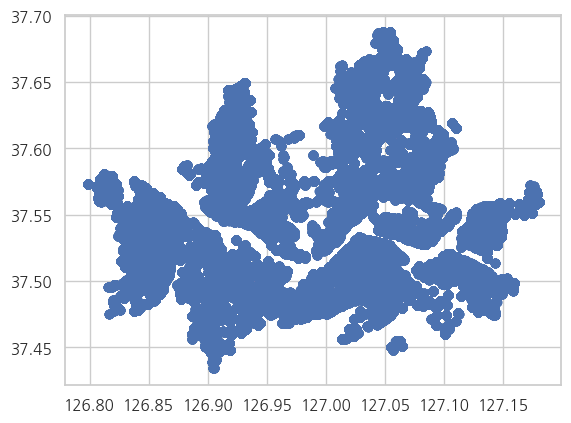

In [19]:
#### X,Y Data Transform with Kakao API #####
# import json
# import requests

# train_address = selected[["아파트명", "좌표X", "좌표Y", "시군구", "번지"]]
# train_address["주소명"] = train_address["시군구"] + ' ' + train_address["번지"]
# apt_name = train_address["아파트명"].unique()


# unique_idx = train_address.drop_duplicates(subset="아파트명").index
# apt_uniq = train_address.iloc[unique_idx].reset_index(drop=True)
# apt_uniq["주소명"] = apt_uniq["시군구"] + ' ' + apt_uniq["번지"]


# def addr_to_lonlat(addr):
#     try:
#         url = 'https://dapi.kakao.com/v2/local/search/address.json?query={address}'.format(address=addr)
#         api_key = '1c97ab54264ea538150a497fe7a76737'
#         headers = {"Authorization": 'KakaoAK ' + api_key }
#         result = json.loads(str(requests.get(url, headers=headers).text))
#         X_new = float(result['documents'][0]['address']['x'])
#         Y_new = float(result['documents'][0]['address']['y'])
#         return X_new, Y_new
#     except:
#         X_new = np.nan
#         Y_new = np.nan
#         return X_new, Y_new


# new_xcoor = []; new_ycoor = []
# for i in range(len(apt_uniq)):
#     x_coor, y_coor = addr_to_lonlat( apt_uniq["주소명"].iloc[i])
#     new_xcoor.append(x_coor)
#     new_ycoor.append(y_coor)

# apt_uniq["좌표X_new"] = new_xcoor
# apt_uniq["좌표Y_new"] = new_ycoor

# apt_uniq.to_csv('../data/xy_new.csv', columns =["아파트명", 좌표X", "좌표Y", "시군구", "번지", "주소명", "좌표X_new", "좌표Y_new"])
# apt_uniq.to_csv('../data/xy_new.csv', columns =["아파트명", '좌표X_new', '좌표Y_new'])

####################################################################################################################################

apt_uniq= pd.read_csv('../data/xy_new.csv')
apt_uniq = apt_uniq.drop([ 'Unnamed: 0'], axis=1)


apt_uniq.drop(index=apt_uniq[apt_uniq["아파트명"].isnull()].index,  axis=0, inplace=True)
apt_uniq.drop(index=apt_uniq[apt_uniq["좌표X_new"].isnull()].index,  axis=0, inplace=True)
apt_uniq.drop(index=apt_uniq[apt_uniq["좌표Y_new"].isnull()].index,  axis=0, inplace=True)
apt_uniq.isnull().sum()

xcoor_map = apt_uniq.set_index('아파트명')["좌표X_new"].to_dict()
ycoor_map = apt_uniq.set_index('아파트명')["좌표Y_new"].to_dict()
del apt_uniq

concat_select['좌표X_new'] = concat_select['아파트명'].map(xcoor_map)
concat_select['좌표Y_new'] = concat_select['아파트명'].map(ycoor_map)

concat_select["좌표X"].fillna(concat_select['좌표X_new'], inplace=True)
concat_select["좌표Y"].fillna(concat_select['좌표Y_new'], inplace=True)
concat_select.drop(["좌표X_new", "좌표Y_new"], axis=1, inplace=True)

print(len(concat_select["좌표X"][concat_select["좌표X"].isna()]), len(concat["좌표X"][concat["좌표X"].isna()]))
print(len(concat_select["좌표Y"][concat_select["좌표Y"].isna()]), len(concat["좌표Y"][concat["좌표Y"].isna()]))

# plt.scatter(apt_uniq['좌표X_new'], apt_uniq['좌표Y_new'])
plt.scatter(concat_select['좌표X'], concat_select['좌표Y'])

In [20]:
print(concat_select['좌표X'].isnull().sum())
print(concat_select['좌표Y'].isnull().sum())

21801
21801


### "Target" 로그 스케일 변환

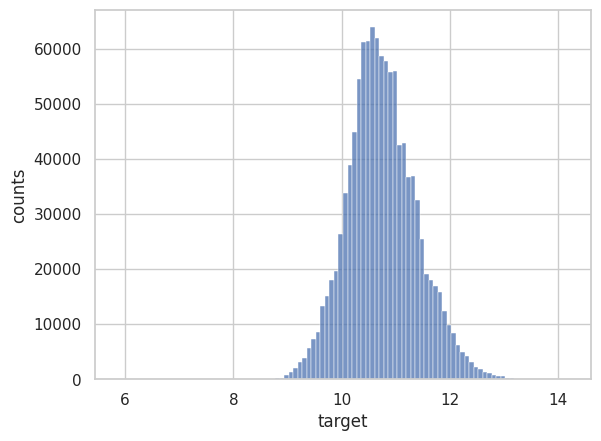

In [21]:
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')

sns.set(style="whitegrid")
sns.histplot(np.log1p(concat_select["target"]), bins=100)
# sns.histplot(np.expm1(np.log1p(concat_select["target"])), bins=100)
# sns.histplot(y_transformed, bins=100)
# sns.histplot(concat_select["target"], bins=100)
plt.xlabel('target')
plt.ylabel("counts")

# BOX-COX 변환
# from scipy.stats import boxcox
# y_transformed, lambda_val = boxcox(concat_select["target"]
# # sns.set(style="whitegrid")
# sns.histplot(np.log1p(concat_select["target"]), bins=100)
# sns.histplot(y_transformed, bins=100)
# plt.xlabel('target')
# plt.ylabel("counts")

################################################################################
concat_select["target"] = np.log1p(concat_select["target"])

### "전용면적" 로그 스케일 변환 --- (X)

In [22]:
# 상관계수 테스트
# corr_test = pd.concat([concat["target"] , concat["전용면적"]], axis=1)
# display(corr_test.corr())
# del corr_test

# concat_select['전용면적']
train_idx = concat_select[concat_select['is_test'] == 0].index
temp_y = concat_select.iloc[train_idx]['target']

corr, p_value = calculate_pearson(concat_select.iloc[train_idx]['전용면적'], temp_y)
print(f"Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

corr, p_value = calculate_pearson(np.log1p(concat_select.iloc[train_idx]['전용면적']), temp_y)
print(f"Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}" + " <log_transformed>")

Pearson Correlation = 0.6272, P-value = 0.0000
Pearson Correlation = 0.6308, P-value = 0.0000 <log_transformed>


Text(0, 0.5, 'counts')

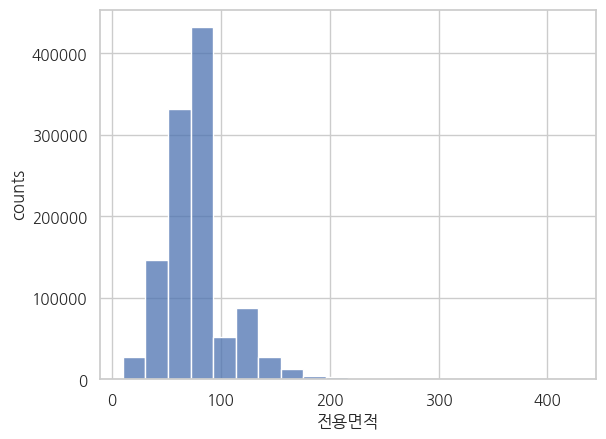

In [23]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')

sns.histplot(concat_select["전용면적"], bins=20)
plt.xlabel('전용면적')
plt.ylabel("counts")

Text(0, 0.5, 'counts')

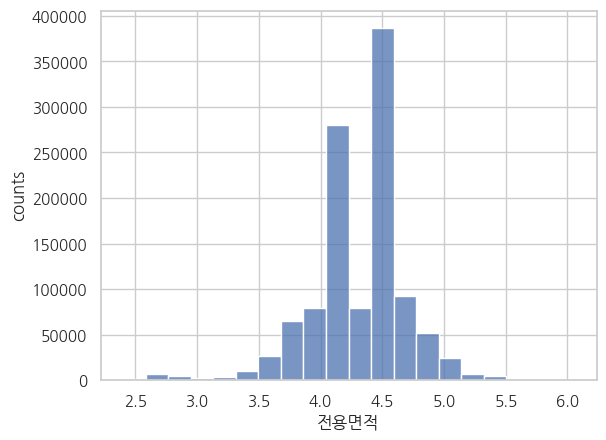

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정
plt.rc('font', family='NanumGothic')

sns.histplot(np.log1p(concat_select["전용면적"]), bins=20)
plt.xlabel('전용면적')
plt.ylabel("counts")

In [25]:
# concat_select['전용면적'] = np.log1p(concat_select['전용면적'])

### <<의미없는 변수 제거>> (1)

In [26]:
concat_select.isnull().sum()

시군구                          0
번지                         227
본번                          75
부번                          75
아파트명                      2136
전용면적                         0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
등기신청일자                       0
거래유형                         0
중개사소재지                       0
단지분류                    877273
전화번호                    876850
팩스번호                    879348
세대타입_분양형태               876125
관리방식                    876125
복도유형                    876454
난방방식                    876125
전체동수                    877207
전체세대수                   876125
건설사_시공사                 877637
시행사                     877834
사용검사일_사용승인일             876259
연면적                     876125
주거전용면적                  876170
관리비부과면적                 876125
전용면적_60이하               876170
전용면적_60~85이하            876170
전용면적_85~135이하           876170
수정일자    

In [27]:
unecessary_var = [
                  '사용허가여부',
                  '관리비 업로드',
                  '팩스번호', 
                  '전화번호',
                  '세대타입_분양형태',
                  '고용보험관리번호',
                  '중개사소재지',                # 지방주소 포함????
                  '등기신청일자',
                  '거래유형',
                  '단지분류',
                  '기타_의무_임대_임의_1_2_3_4',
                  '관리방식',
                  '복도유형',
                  '전체동수',
                  '건설사_시공사',
                  '시행사',
                  '경비비관리형태',             # 경비비관리형태와 매우 유사함
                  '세대전기계약방법',
                  '단지신청일',
                  '단지승인일',
                  '수정일자',
                  '사용검사일_사용승인일',
                  '연면적',
                  '주거전용면적',
                  '관리비부과면적',
                  '건축면적',
                  '전체세대수'
                  ]

for col in unecessary_var:
    concat_select.drop(col, axis=1, inplace=True)

concat_select.isnull().sum()

시군구                    0
번지                   227
본번                    75
부번                    75
아파트명                2136
전용면적                   0
계약년월                   0
계약일                    0
층                      0
건축년도                   0
도로명                    0
난방방식              876125
전용면적_60이하         876170
전용면적_60~85이하      876170
전용면적_85~135이하     876170
청소비관리형태           877751
주차대수              876277
좌표X                21801
좌표Y                21801
target              9272
is_test                0
전용면적_135초과       1127765
dtype: int64

### <<의미없는 변수 제거>> (2)

In [28]:
unecessary_var = [
                "난방방식",
                "전용면적_60이하",
                "전용면적_60~85이하",
                "전용면적_85~135이하",
                "전용면적_135초과",
                "청소비관리형태",
                "주차대수"
                  ]

for col in unecessary_var:
    concat_select.drop(col, axis=1, inplace=True)

concat_select.isnull().sum()

시군구            0
번지           227
본번            75
부번            75
아파트명        2136
전용면적           0
계약년월           0
계약일            0
층              0
건축년도           0
도로명            0
좌표X        21801
좌표Y        21801
target      9272
is_test        0
dtype: int64

### Option 1 : X,Y 결측치 보완

In [29]:
concat_select.isnull().sum()

시군구            0
번지           227
본번            75
부번            75
아파트명        2136
전용면적           0
계약년월           0
계약일            0
층              0
건축년도           0
도로명            0
좌표X        21801
좌표Y        21801
target      9272
is_test        0
dtype: int64

In [30]:
concat_select2 = concat_select.copy()

tmp_xy = ['좌표X', '좌표Y']
# concat_select2[tmp_xy] = concat_select2[tmp_xy].applymap(lambda x: x if pd.notnull(x) else 0)

# 전방치환
concat_select2['좌표X'] = concat_select2['좌표X'].fillna(method='ffill')
concat_select2['좌표Y'] = concat_select2['좌표Y'].fillna(method='ffill')

# concat_select2[tmp_xy] = concat_select2[tmp_xy].interpolate(method='nearest', axis=0)

# concat_select.drop(columns=tmp_xy, axis=1, inplace=True)

In [31]:
# plt.scatter(concat_select2['좌표X'], concat_select2['좌표Y'])

In [32]:
# concat_select.isnull().sum()
# concat_select2.isnull().sum()
concat_select = concat_select2
del concat_select2

### Option 2 : X,Y 결측치 Class 제거 --- (O)

In [33]:
################  X,Y 데이터 결측치 있는 Class 날려버리기 ################
# concat_select2 = concat_select.copy()


# xy_fault_idx = concat_select2.iloc[concat_select2[concat_select2['좌표X'].isnull()].index].index
# concat_select2 = concat_select2.iloc[concat_select2[concat_select2['좌표Y'].isnull()].index]

# concat_select2.drop(xy_fault_idx, inplace=True)
# concat_select2 = concat_select2.reset_index(drop=True)

In [34]:
# concat_select = concat_select2.copy()
# del concat_select2

In [35]:
concat_select.isnull().sum()

시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
좌표X           0
좌표Y           0
target     9272
is_test       0
dtype: int64

## (2) 범주형 연속형 분리

In [36]:
num_cols = concat_select.select_dtypes(include=['int','float']).columns
obj_cols = concat_select.select_dtypes(include=['object']).columns
len(num_cols) + len(obj_cols) == len(concat_select.columns)

True

In [37]:
num_cols

Index(['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target',
       'is_test'],
      dtype='object')

In [38]:
obj_cols

Index(['시군구', '번지', '아파트명', '도로명'], dtype='object')

## (3) EDA 최종 데이터프레임 생성

In [39]:
df_a = pd.DataFrame()
train_a = pd.DataFrame()
test_a = pd.DataFrame()

df_a['is_test'] = concat_select['is_test']

In [40]:
display(df_a.value_counts())
len(df_a[df_a['is_test']==1])

is_test
0          1118822
1             9272
dtype: int64

9272

### 1. 시 군 구 동

In [41]:
df_a['시'] = concat_select['시군구'].str.split(expand=True)[0]
df_a['구'] = concat_select['시군구'].str.split(expand=True)[1]
df_a['동'] = concat_select['시군구'].str.split(expand=True)[2]

concat_select.drop(columns=['시군구'], axis=1, inplace=True)

In [42]:
df_a.head()

,is_test,시,구,동
0,0,서울특별시,강남구,개포동
1,0,서울특별시,강남구,개포동
2,0,서울특별시,강남구,개포동
3,0,서울특별시,강남구,개포동
4,0,서울특별시,강남구,개포동


In [43]:
print(df_a['시'].value_counts())
df_a['시'].unique()
df_a.drop(columns='시', axis=1, inplace=True)

서울특별시    1128094
Name: 시, dtype: int64


In [44]:
df_a = pd.concat([ df_a , pd.get_dummies(df_a['구']) ] , axis=1 )
df_a.drop(columns='구', axis=1, inplace=True)
df_a['강남구']

0          1
1          1
2          1
3          1
4          1
          ..
1128089    0
1128090    0
1128091    0
1128092    0
1128093    0
Name: 강남구, Length: 1128094, dtype: uint8

In [45]:
print(len(df_a['동'].unique()))   ## 337개

result = df_a['동'].value_counts().sort_values()
result
label_a = {value : i for i, value in enumerate(result.index, start=1)}
df_a['동'] = df_a['동'].map(label_a)

337


In [46]:
df_a['동']

0          319
1          319
2          319
3          319
4          319
          ... 
1128089    321
1128090    321
1128091    321
1128092    321
1128093    321
Name: 동, Length: 1128094, dtype: int64

### 2. 아파트명

In [47]:
concat_select['아파트명'].isnull().sum()

2136

### (+++ 추가 인접 거리)

In [48]:
# import math 

# def haversine_distance(lat1, lon1, lat2, lon2):
#     radius = 6371.0

#     lat1 = math.radians(lat1)
#     lon1 = math.radians(lon1)
#     lat2 = math.radians(lat2)
#     lon2 = math.radians(lon2)

#     dlon = lon2 - lon1
#     dlat = lat2 - lat1
#     a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     distance = radius * c
#     return distance

In [49]:
# schools = pd.read_csv('../data/schools.csv', encoding='cp949')
# subway = pd.read_csv('../data/subway_feature.csv')

# def distance_for_xy(target_loc):
#     distance_target = []
#     for i in range(len(coor_uniq)):
#     # for i in range(500):
#         distance_temp = []
#         for j in range(len(target_loc)):
#             try:
#                 # distance = haversine_distance(coor_for_distance["좌표Y"].iloc[i], coor_for_distance["좌표X"].iloc[i], target_loc["위도"].iloc[j], target_loc["경도"].iloc[j] )
#                 distance = haversine_distance(coor_uniq["좌표Y"].iloc[i], coor_uniq["좌표X"].iloc[i], target_loc["위도"].iloc[j], target_loc["경도"].iloc[j] )
#                 distance_temp.append(distance)
#             except:
#                 distance = np.nan
#                 distance_temp.append(distance)
#         distance_min = min(distance_temp)
#         distance_target.append(distance_min)
#     return distance_target

# min_distance_schools = distance_for_xy(schools)
# min_distance_schools = distance_for_xy(schools)
# min_distance_subways = distance_for_xy(subway)

# coor_uniq["인접지하철거리"] = min_distance_subways
# coor_uniq.to_csv('subway_dist.csv')
# coor_uniq["인접학교거리"] = min_distance_schools
# coor_uniq.to_csv('school_distance.csv')

In [50]:
coor_uniq2 = pd.read_csv('../data/dist_subway.csv', encoding='utf-8')
coor_uniq3 = pd.read_csv('../data/dist_school.csv', encoding='utf-8')
coor_uniq2.drop("Unnamed: 0",axis=1, inplace=True)
coor_uniq3.drop("Unnamed: 0",axis=1, inplace=True)


concat_select2 = concat_select.copy()

sub_dist = coor_uniq2.set_index('아파트명')['인접지하철거리'].to_dict()
sub_dist2 = coor_uniq3.set_index('아파트명')['인접학교거리'].to_dict()
concat_select2['인접지하철거리'] = concat_select2['아파트명'].map(sub_dist)
concat_select2['인접학교거리'] = concat_select2['아파트명'].map(sub_dist2)

# 

In [51]:
concat_select = concat_select2.copy()
del concat_select2

In [52]:
concat_select.isnull().sum()

번지           227
본번            75
부번            75
아파트명        2136
전용면적           0
계약년월           0
계약일            0
층              0
건축년도           0
도로명            0
좌표X            0
좌표Y            0
target      9272
is_test        0
인접지하철거리    13502
인접학교거리     13502
dtype: int64

In [53]:
concat_select['인접지하철거리'] = concat_select['인접지하철거리'].fillna(method='ffill')
concat_select['인접학교거리'] = concat_select['인접학교거리'].fillna(method='ffill')

In [54]:
concat_select.isnull().sum()

번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
좌표X           0
좌표Y           0
target     9272
is_test       0
인접지하철거리       0
인접학교거리        0
dtype: int64

In [55]:
# tmp1 = concat_select.query('is_test==1')
# tmp0 = concat_select.query('is_test==0')

# df_a.iloc[tmp1[tmp1['아파트명'].isnull()].index]
# xtmp = concat_select.iloc[tmp1[tmp1['아파트명'].isnull()].index]['좌표X'].iloc[0]
# concat_select.iloc[tmp1[tmp1['아파트명'].isnull()].index]['좌표Y']
# print(xtmp, ytmp)

# tmp0["아파트명"].isnull().sum()
# concat_select["아파트명"].isnull().sum()

In [56]:
tmp_a = concat_select[concat_select['아파트명'].isnull()==1]

# 도로명 기준으로 아파트명 새로 지정 ---> 2136 아파트명 중 동일 도로명 284 (기타아파트1 ~ 기타아파트337)
# len(tmp_a['도로명'].unique())
# tmp_a['도로명'].value_counts()

apt_value = tmp_a['도로명'].value_counts().sort_values()
apt_class = {value : '기타'+str(i) for i, value in enumerate(apt_value.index, start=1)}

# concat_select[concat_select["아파트명"].isnull()]
# display(concat.iloc[concat_select[concat_select["아파트명"].isnull()].index])
# display(concat_select.iloc[concat_select[concat_select["아파트명"].isnull()].index])

concat_select2 = concat_select.copy()
concat_select2['아파트명_fill'] = concat_select2['도로명'].map(apt_class)
concat_select2["아파트명_fill"].isnull().sum()
concat_select2[concat_select2['아파트명_fill'].isnull()==0]
concat_select2['아파트명'].fillna(concat_select2["아파트명_fill"], inplace=True)
concat_select2.drop(columns = '아파트명_fill', axis=1, inplace=True)


In [57]:
apt_result = concat_select2['아파트명'].value_counts().sort_values()
apt_label = {value: i for i, value in enumerate(apt_result.index, start=1)}
df_a['아파트명'] = concat_select2['아파트명'].map(apt_label)

In [58]:
concat_select = concat_select2.copy()
del concat_select2
concat_select.drop(columns='아파트명', axis=1, inplace=True)

In [59]:
# display(df_a["아파트명"].value_counts())
display(len(df_a["아파트명"].unique()))
# df_a["아파트명"]

6833

### 3. 도로명

In [60]:
# len(concat_select['도로명'].unique())

concat_select['도로명'] = concat_select['도로명'].str.split(' ',expand=True)[0]
concat_select['도로명'].value_counts()

concat_select2 = concat_select.copy()
concat_select2['도로명'] = concat_select2['도로명'].str.replace(r"\d+\D?길$", '', regex=True)

tmp = concat_select2['도로명'].value_counts().sort_values()
value_to_label = {value: i for i, value in enumerate(tmp.index, start=1)}

df_a["도로명"] = concat_select2['도로명'].map(value_to_label)
concat_select2.drop(columns='도로명', axis=1, inplace=True)
concat_select = concat_select2.copy()
del concat_select2


In [61]:
# df_a.isnull().sum()
# df_a.info()
concat_select.isnull().sum()

번지          227
본번           75
부번           75
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
좌표X           0
좌표Y           0
target     9272
is_test       0
인접지하철거리       0
인접학교거리        0
dtype: int64

### 4. 건축년도 + 건축년도별 mean

<Axes: xlabel='건축년도', ylabel='target'>

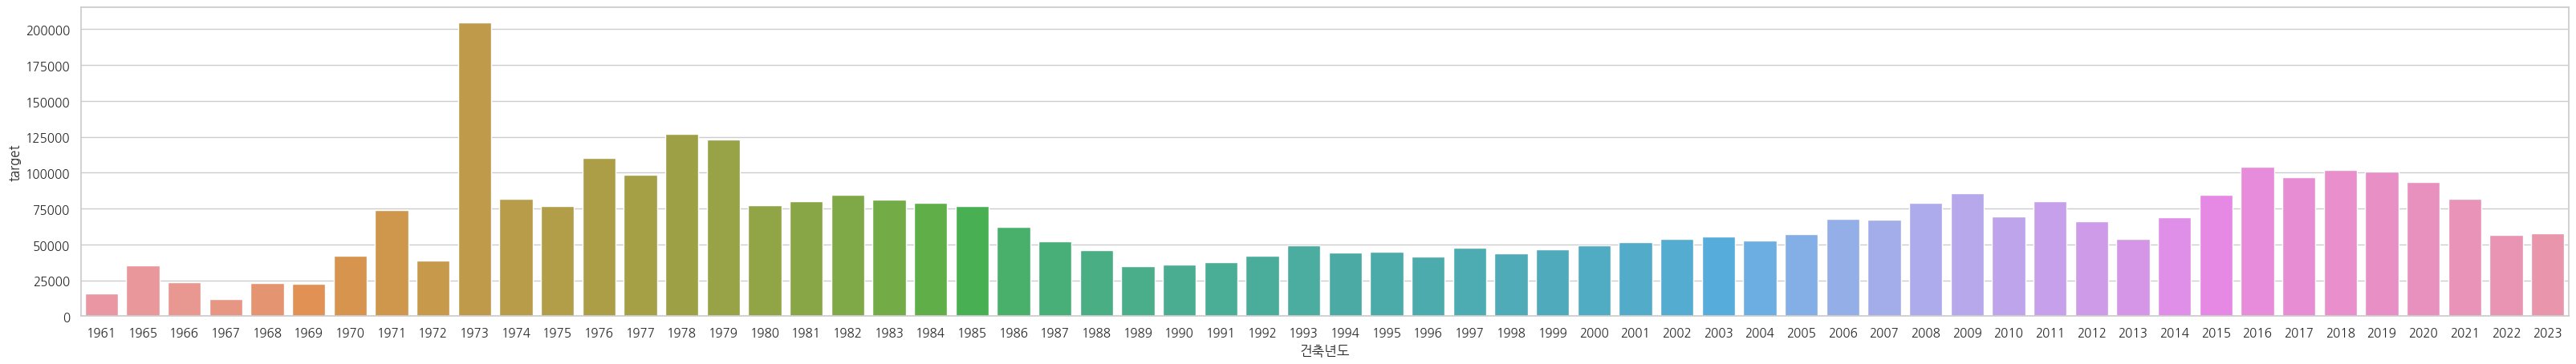

In [62]:
t_var = "건축년도"

tmp_idx = concat_select[~concat_select[t_var].isnull()].index
tmp_data = concat_select[[t_var , "target"]].iloc[tmp_idx]
tmp_data2 = concat[[t_var, "target"]].iloc[tmp_idx]


mean_value = pd.DataFrame(tmp_data2.groupby(t_var)["target"].mean())                        # Non-Scaled
# mean_value = np.log1p(pd.DataFrame(tmp_data.groupby(t_var)["target"].mean()))             # Scaled


plt.figure(figsize=(40,5))
sns.barplot(x=mean_value.index, y=mean_value["target"])

# sns.histplot(tmp_data[t_var])
# sns.histplot(x=tmp_data[t_var], y=tmp_data2["target"])
# sns.histplot(x=tmp_data["관리방식"], y=tmp_data2["target"], bins=3)

In [63]:
mean_dict = mean_value.set_index(mean_value.index)["target"].to_dict()
concat_select['년도별_평균거래가'] = concat_select['건축년도'].map(mean_dict)
df_a['년도별_평균거래가'] = concat_select['년도별_평균거래가']

In [64]:
corr, p_value = calculate_pearson(concat_select.iloc[train_idx]['년도별_평균거래가'], temp_y)
print(f"Pearson Correlation = {corr:.4f}, P-value = {p_value:.4f}")

Pearson Correlation = 0.3734, P-value = 0.0000


<Axes: xlabel='년도별_평균거래가', ylabel='Count'>

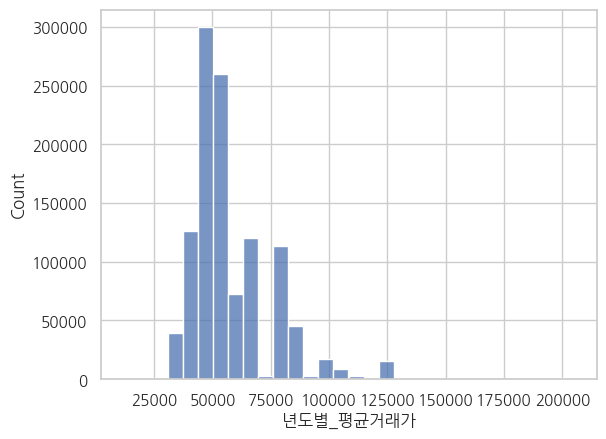

In [65]:
sns.histplot(df_a["년도별_평균거래가"], bins=30)

### 5. 번지 / 본번, 부번

In [66]:
# 번지 (본번이랑 곂쳐서 날리기)
concat_select2 = concat_select.copy()
concat_select2['번지'] = concat_select2['번지'].str.split('-',expand=True)[0]
concat_select2.drop(columns="번지", axis=1, inplace=True)

In [67]:
# Option 1 살리기 (interp)

# tmp_cols = ['본번', '부번']
# concat_select2[tmp_cols] = concat_select2[tmp_cols].applymap(lambda x: int(x) if pd.notnull(x) else 0)
# concat_select2[tmp_cols] = concat_select2[tmp_cols].interpolate(method='nearest', axis=0)
# concat_select2[tmp_cols] = concat_select2[tmp_cols].interpolate(method='ffill', axis=0)

In [68]:
# Option 2 날리기

tmp_idx1 = concat_select2[concat_select2['본번'].isnull() | concat_select2['부번'].isnull() ].index
concat_select2.drop(tmp_idx1, inplace=True)


df_a = df_a.reset_index(drop=True)
df_a.drop(tmp_idx1, inplace=True)


In [69]:
# index reset 하기
concat_select2 = concat_select2.reset_index(drop=True)
df_a = df_a.reset_index(drop=True)

In [70]:
concat_select = concat_select2.copy()
del concat_select2

df_a['본번'] = concat_select['본번']
df_a['부번'] = concat_select['부번']
concat_select.drop(columns='본번',axis=1, inplace=True)
concat_select.drop(columns='부번',axis=1, inplace=True)

In [71]:
len(concat_select.query("is_test==1"))

9272

### 6. 계약년월일 (+계약년도별 평균거래가)

In [72]:
concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])

In [73]:
df_a["계약년월일"] = concat_select['계약년월'].astype(str) + concat_select['계약일'].astype(str).str.zfill(2)

In [74]:
feat_rest = ['전용면적', '건축년도','층',  '좌표X', '좌표Y']
df_a[feat_rest] = concat_select[feat_rest]
# concat_select.drop(columns=[feat_rest], axis=1, inplace=True)

### (+추가사항)

<Axes: xlabel='계약년', ylabel='target'>

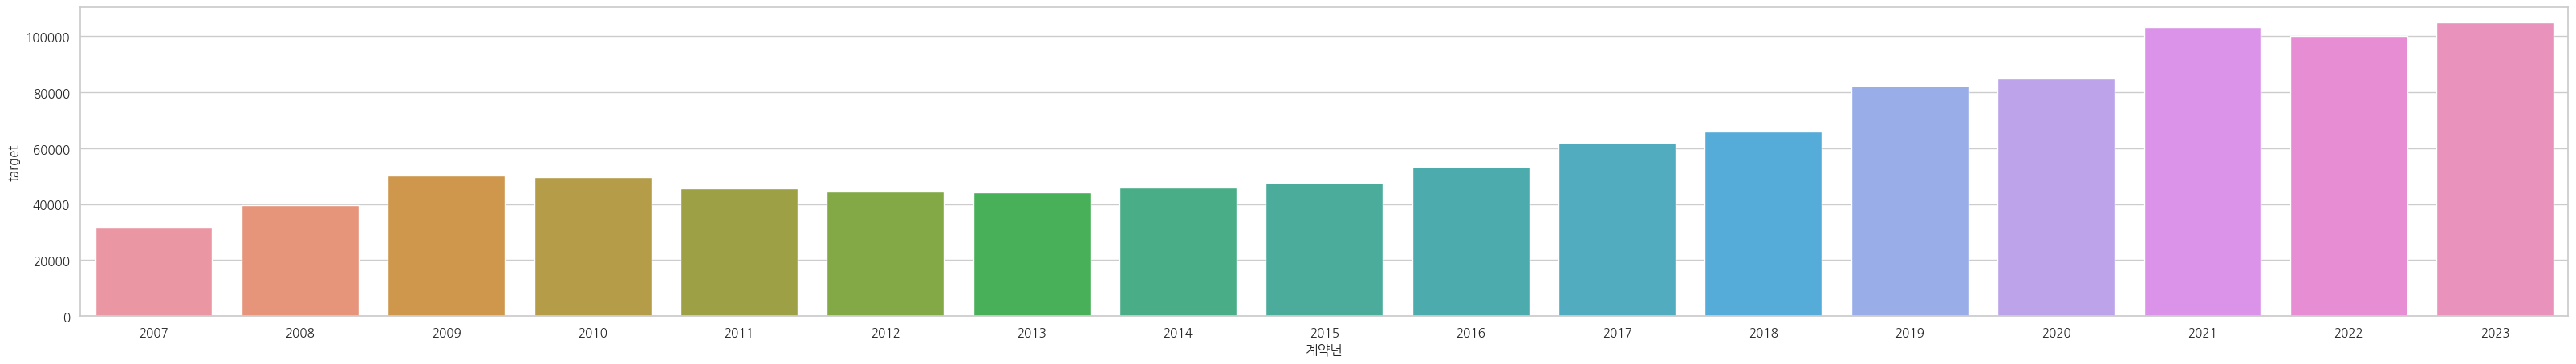

In [75]:
t_var = "계약년"

concat_select2 = concat_select.copy()
concat_select2["target"] = np.expm1(concat_select2["target"])
# tmp_data = concat[[t_var, "target"]].iloc[tmp_idx]


mean_value2 = pd.DataFrame(concat_select2.groupby(t_var)["target"].mean())                        # Non-Scaled
# mean_value2 = np.log1p(pd.DataFrame(tmp_data.groupby(t_var)["target"].mean()))             # Scaled


plt.figure(figsize=(40,5))
sns.barplot(x=mean_value2.index, y=mean_value2["target"])


In [76]:

# df_a.drop(columns='level_0', inplace=True)

In [77]:
mean_dict = mean_value2.set_index(mean_value2.index)["target"].to_dict()
concat_select2['계약년도별_평균거래가'] = concat_select2['계약년'].map(mean_dict)
df_a['계약년도별_평균거래가'] = concat_select2['계약년도별_평균거래가']

## (4) 추가 파행변수

In [78]:
concat_select['평균거래가 가중치'] = concat_select['년도별_평균거래가'].apply(lambda x: 1 if x >= 60000 else 0)
concat_select['평균거래가 가중치'] = concat_select['년도별_평균거래가'].apply(lambda x: 2 if x >= 100000 else 0)
concat_select['평균거래가 가중치'] = concat_select['년도별_평균거래가'].apply(lambda x: 3 if x >= 150000 else 0)


df_a['평균거래가 가중치'] = concat_select['평균거래가 가중치']

In [79]:
concat_select2['평균거래가 가중치2'] = concat_select2['계약년도별_평균거래가'].apply(lambda x: 1 if x >= 50000 else 0)

df_a['평균거래가 가중치2'] = concat_select2['평균거래가 가중치2']

In [80]:
# year_th = 2015
# concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 2 if x == 1973 else 0)
# concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= year_th else 0)

# df_a['신축여부'] = concat_select['신축여부']

In [81]:
concat_select.columns

Index(['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test',
       '인접지하철거리', '인접학교거리', '년도별_평균거래가', '계약년', '계약월', '평균거래가 가중치'],
      dtype='object')

In [82]:
mean_sub_dist = concat_select2[concat_select2["인접지하철거리"] < 100]["인접지하철거리"].mean()
mean_school_dist = concat_select2[concat_select2["인접학교거리"] < 100]["인접학교거리"].mean()
# # concat_select["인접학교거리"]
# # sns.boxplot(concat_select["인접지하철거리"])
# concat_select["인접학교거리"].
concat_select2["인접학교거리"] = concat_select2["인접학교거리"].map(lambda x: mean_school_dist if x > 100 else x)
concat_select2["인접지하철거리"] = concat_select2["인접지하철거리"].map(lambda x: mean_sub_dist if x > 100 else x)
# concat_select["인접치하철거리"]

In [83]:
feat_rest = ['인접학교거리', '인접지하철거리']
df_a[feat_rest] = concat_select2[feat_rest]

## (Save)

In [84]:
# del tmp, tmp_a, tmp_data, tmp_data2
# del tmp_xy
# del tmp_idx
# del train_a

In [85]:
y = concat_select[concat_select["is_test"]==0]['target']

In [86]:
df_a["is_test"].value_counts()

0    1118747
1       9272
Name: is_test, dtype: int64

In [87]:
y.isnull().sum()

0

In [88]:
pre_train = df_a.query('is_test==0')
pre_test = df_a.query('is_test==1')

pre_train.drop(['is_test'], axis=1, inplace=True)
pre_test.drop(['is_test'], axis=1, inplace=True)

print(pre_train.shape, pre_test.shape, y.shape)

pre_train.to_csv("../data/pre_train3.csv", index=False)
pre_test.to_csv("../data/pre_test3.csv", index=False)
y.to_csv("../data/target3.csv", index=False)

(1118747, 42) (9272, 42) (1118747,)
